<a href="https://colab.research.google.com/github/byrdwcrawford/HR_Analytics/blob/main/HR_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Attrition Prediction  
### Will Byrd June 2024  

## Introduction  

In this notebook, we will take a look at an HR Analytics dataset and perform a binary classification to determine Attrition.  Attrition is the departure of an employee from an organization fro any reason.  In this dataset we do not have context on why the emlpoyee leaves the company-they may have been fired or they may have resigned.  

For companies and orgnizations-the employees are the most important asset.  Therefore, it is vitally important to be able to predict behavior of these employees.  Knowing which employees will stay with the company can:  

* Reduce turnover costs  
  * Hiring and firing employees is expensive  
* Increase employee engagement and morale  
  * It can be difficult to maintain strong company culture if turnover is high  
* Assist with resource planning  
  * Companies can add resources to employees they believe will contribute to longterm growth
  * Conversely, companies can take proactive measures to retain at risk employees
* Improve customer relationships  
  * Customer percieve companies that retain talent more positively
* Enhance company reputation  
  * Company brand is often times tied to the employees interacting with the customers


## Data  

HR Analytics data was collected [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).  This is a 228 kB, publicly available csv file with 1479 rows and 35 columns from Kaggle.  Important features are going to be our target value **'Attrition'**, and various features such as:  

* Job Satisfaction
* Age
* Sex
* Job Title
* Salary  

### Data Preperation  

This dataset is already cleaned, but some processing still needs to occur.  We will need to:  

* Engineer Features  
  * Combining, Transforming columns
  * Label Encoding, One-Hot Encoding categorical features
* Dropping Columns  
* Balancing Classes  
  * The class imblance issue will be a limitation of this dataset and a tradeoff between overall accuracy and Recall will happen  

### Goals  

The main goal of our model is to maximize **accuracy**.  Accuracy will be important here as being able to accurately predict which employees will stay and which will leave is important.  It's also important to understand that since we don't know if employees are fired and which ones quit, simply targeting the positive Attrition class (Recall) will still not tell the entire story.  

Here are the metrics we will be looking at for this business case:  

* Accuracy-Overall accuracy of our model  

* Precision-Accuracy of positive predictions made by our model  
  * High Precision indicates that an employee will leave, it is usually correct.  **High Precision minimizes false positives.**    

* Recall-The ability of our model to identify the actual positive observations  
  * High Recall is going to be tough with this dataset specifically since we are battling a class imbalance issue.  As we will see in our dataset, nearly 15% of our data is the positive **Attrition** class.  
  
* F1-Score that factors in both Precision and Recall

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ibm-hr-analytics-attrition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1067%2F1925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T150521Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5d3679cf59d2ac8f006ea5d39d7a3ea2ce8d0327ac804a7857fa7a10f4d340c9ef1e4f3372aba9315574f49d72c5c53c7d92259577e8e90bf077f60a5eaa3728e51b2d02c4ed7a66b254fd02f1ab5a2434325e71b8fa4826bb5f52ae3a133c1a1cb4dd80eda1b220252eb1e0e639cd57768cfdfb9979c8df45c6b1cd0af6f25ebb8d56d438ba3e9ce9ccfd1d6e343132418a12a0c2368698d982732cf1b3bac945e0531c8411f26d5578dc8b55ec4387fa8beb78d997e326833ada9f431b1a024a07caafc1057d288175e49123b4336d684174fc646388710be9ba3965d9f9683f4508143434939930ce5909c03743e469f5ce932fb95ecc86bdd4c38657a5be'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 51314 bytes downloaded
Downloaded and uncompressed: ibm-hr-analytics-attrition-dataset
Data source import complete.


Importing all of our libraries and modules for data analysis, feature engineering and modeling.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt

Reading in our dataset as df.

In [ ]:
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### EDA

We will perform the following:  

* View the info  
* Dropping unnecesary columns  
* Feature engineering  
* Creating Visualizations to better understand the data  

  
  
Quick view of info.  Notice no NaN values in our dataset!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Confirmation of no NaN values

In [ ]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

These columns below don't offer any value to our statistical analysis, so they can be removed.

In [ ]:
df = df.drop(columns=[
    'Over18',
    'EmployeeCount',
    'StandardHours',
    'EmployeeNumber'

])

Let's create a new column that shows the relationship between 2 similar features- 'YearsInCurrentRole' and 'YearsAtCompany'.  Because some people will have been at the company for less than a year, we need to turn NaN values to 0, since this will affectively have the same effect we are looking for.

In [ ]:
# Create the new feature with division
df['YearsInCurrentRole_vs_YearsAtCompany'] = df['YearsInCurrentRole'] / df['YearsAtCompany']

# Replace NaN values with 0
df['YearsInCurrentRole_vs_YearsAtCompany'].fillna(0, inplace=True)

# Verify changes
print(df[['YearsInCurrentRole', 'YearsAtCompany', 'YearsInCurrentRole_vs_YearsAtCompany']].head())


   YearsInCurrentRole  YearsAtCompany  YearsInCurrentRole_vs_YearsAtCompany
0                   4               6                              0.666667
1                   7              10                              0.700000
2                   0               0                              0.000000
3                   7               8                              0.875000
4                   2               2                              1.000000


Let's create some more new columns to better illustrate the relationship between years in current job status, amount of travel, and overall satisfaction.

In [ ]:
df['TotalYearsCurrentJob'] = df['YearsInCurrentRole'] + df['YearsWithCurrManager']


In [ ]:
#df['FrequentBusinessTravel'] = df['BusinessTravel'].apply(lambda x: 1 if x == 'Travel_Frequently' else 0)


In [ ]:
df['JobEnvSatisfaction'] = df['JobSatisfaction'] + df['EnvironmentSatisfaction']


Quick view of the df again.

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsInCurrentRole_vs_YearsAtCompany,TotalYearsCurrentJob,JobEnvSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,8,0,1,6,4,0,5,0.666667,9,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,10,3,3,10,7,1,7,0.700000,14,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,7,3,3,0,0,0,0,0.000000,0,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,8,3,3,8,7,3,0,0.875000,7,7
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,6,3,3,2,2,2,2,1.000000,4,3


Here is the imbalancing mentioned earlier.  We can see the majority class outweighs our majority class.

In [ ]:
attrition_counts = df['Attrition'].value_counts(normalize=True) * 100

# Print the results
print(attrition_counts)

Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


* EDA
* Create some visualizations based on data     
* Try only oversampling to preserve data  
* Feature Engineering  
  * Scaling
  * Combining
  * Transform
  * Creating extra columns
* Outlier Detection  
* Correlation   

Models to build  

* Decision Tree Classifier
* KNN

Now let's look at some visualizations.  First things first is the distribution of 'Age' across all employees.  We can see it has a slight skew to the right, which makes sense, because most employees tend to be entry level or early in their career and then some older executives will skew the distribution.  

We will use the Seaborn library to build most of these visualizations.

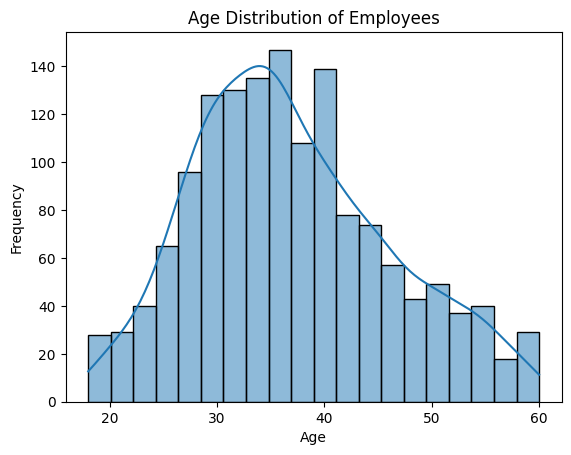

In [ ]:
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Employees')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Let's see if there is any relationship between 'Age' and 'Attrition'   

Based on what we see, it looks like mostly employees early in their career or in mid-level positions are leaving the company and fewer senior/executive aged employees are leaving.

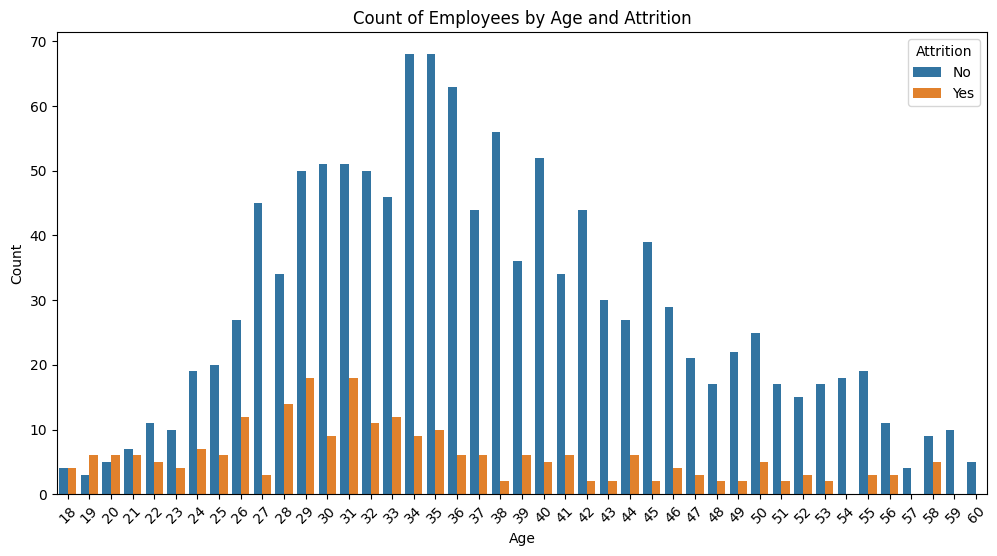

In [ ]:
att_age_group = df.groupby(['Attrition', 'Age']) # creating 'att_age_group' for visualizing
group_sizes = att_age_group.size()

# Convert group_sizes to DataFrame for easier manipulation
group_sizes_df = group_sizes.reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(data=group_sizes_df, x='Age', y='Count', hue='Attrition')
plt.title('Count of Employees by Age and Attrition')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Let's take a quick look at the employees who leave the company based on their 'Gender'.  While this column name is 'Gender', it is actually referring to sex.  

1st thing to notice is there are more males than females.

In [ ]:
att_gen_group = df.groupby(['Attrition', 'Gender'])
att_gen_group = att_gen_group.size()
print(att_gen_group)


Attrition  Gender
No         Female    501
           Male      732
Yes        Female     87
           Male      150
dtype: int64


Let's visualize that.

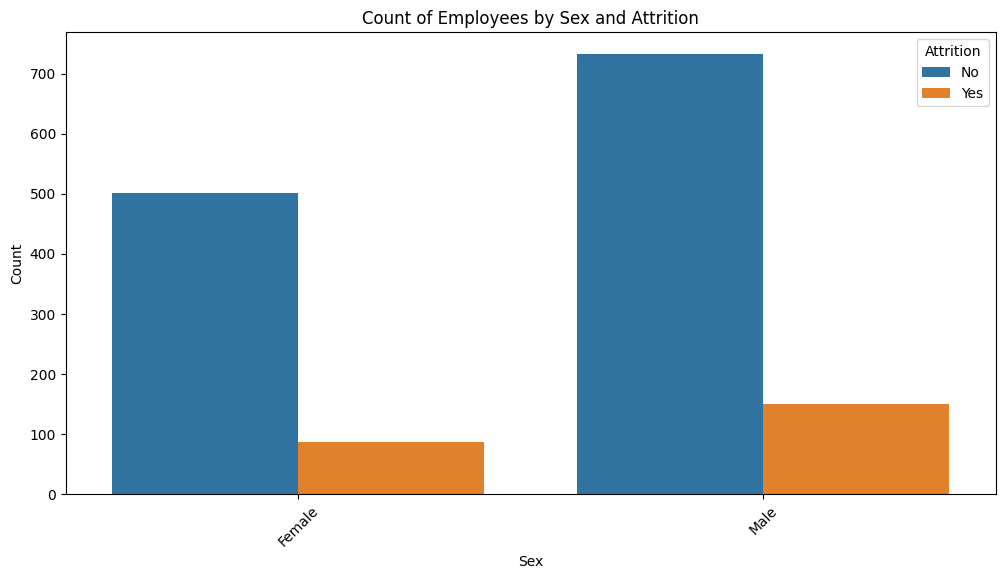

In [ ]:
# Convert group_sizes to DataFrame for easier manipulation
att_gen_df = att_gen_group.reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(data=att_gen_df, x='Gender', y='Count', hue='Attrition')
plt.title('Count of Employees by Sex and Attrition')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Again, we can visualize, of the sexes, which is leaving the company more and it is Male.  We will also create a new **'terminated_df'** that   holds only the rows where the **'Attrition'** value is **Yes**.

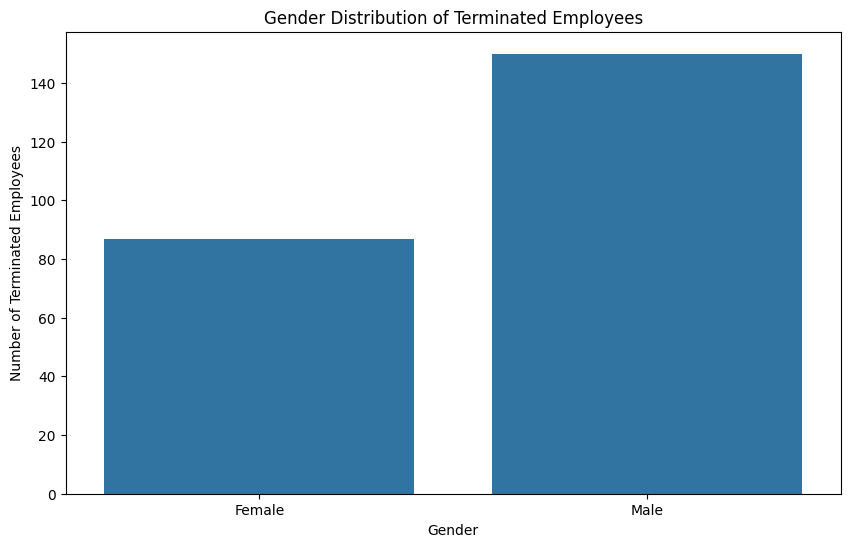

In [ ]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='Gender')
plt.title('Gender Distribution of Terminated Employees')
plt.xlabel('Gender')
plt.ylabel('Number of Terminated Employees')
plt.show()

And let's visualize this another way.

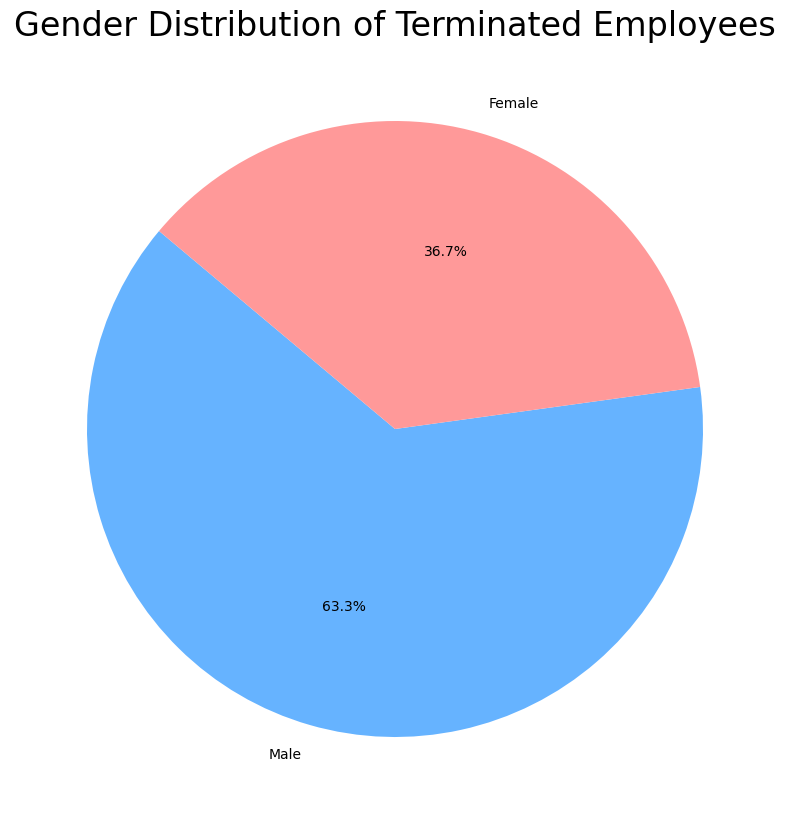

In [ ]:
# Calculate the distribution of genders
gender_counts = terminated_df['Gender'].value_counts()

# Plot the gender distribution of terminated employees as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Gender Distribution of Terminated Employees', fontsize=24)

# Show the plot
plt.show()

Next, let's take a look at Frequency of travel amongst employees who left the company.

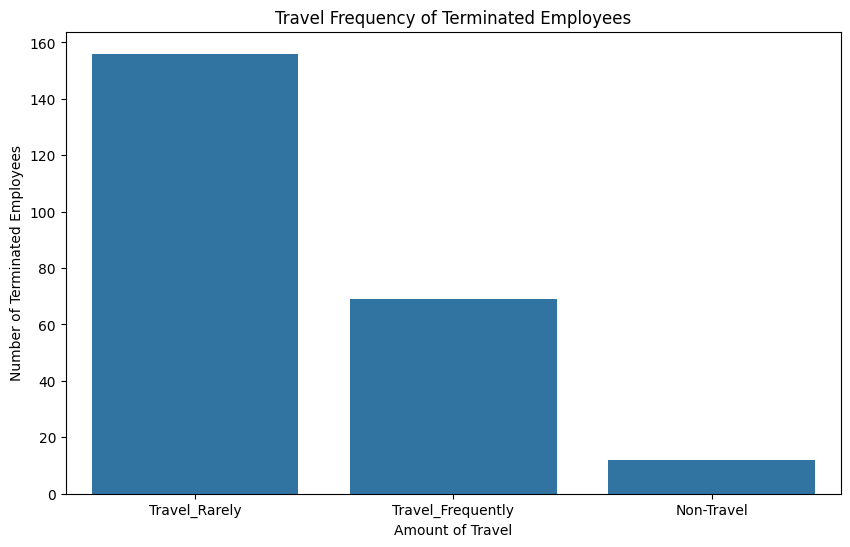

In [ ]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='BusinessTravel')
plt.title('Travel Frequency of Terminated Employees')
plt.xlabel('Amount of Travel')
plt.ylabel('Number of Terminated Employees')
plt.show()

Now let's take a look at the distribution of  of terminated employees based on the department they work in.  The Research and Development Department has seen the most amount of employees who 'Attrition'.

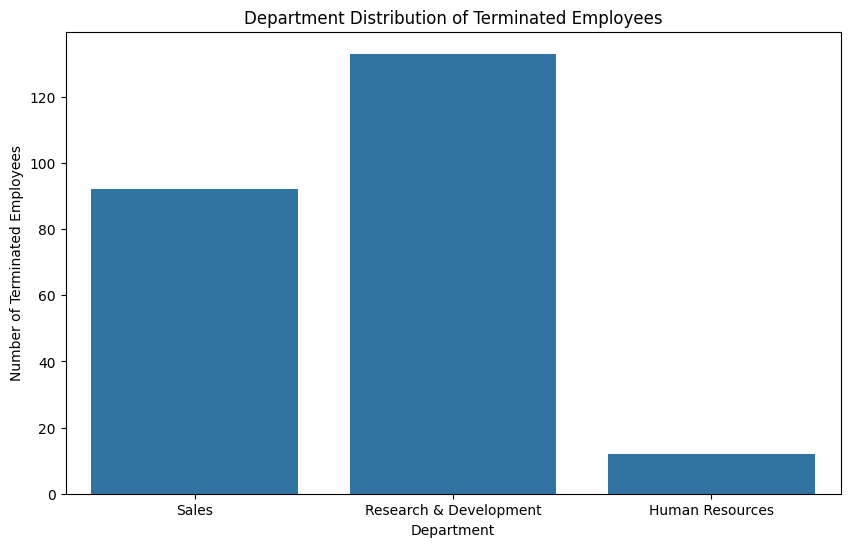

In [ ]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='Department')
plt.title('Department Distribution of Terminated Employees')
plt.xlabel('Department')
plt.ylabel('Number of Terminated Employees')
plt.show()

Now let's take a look at the distribution of employees who leave the company based on their job title.  Below are the top 3 titles of employees of leave the company.

* Lab Tech  
* Sales Exec  
* Research Scientist

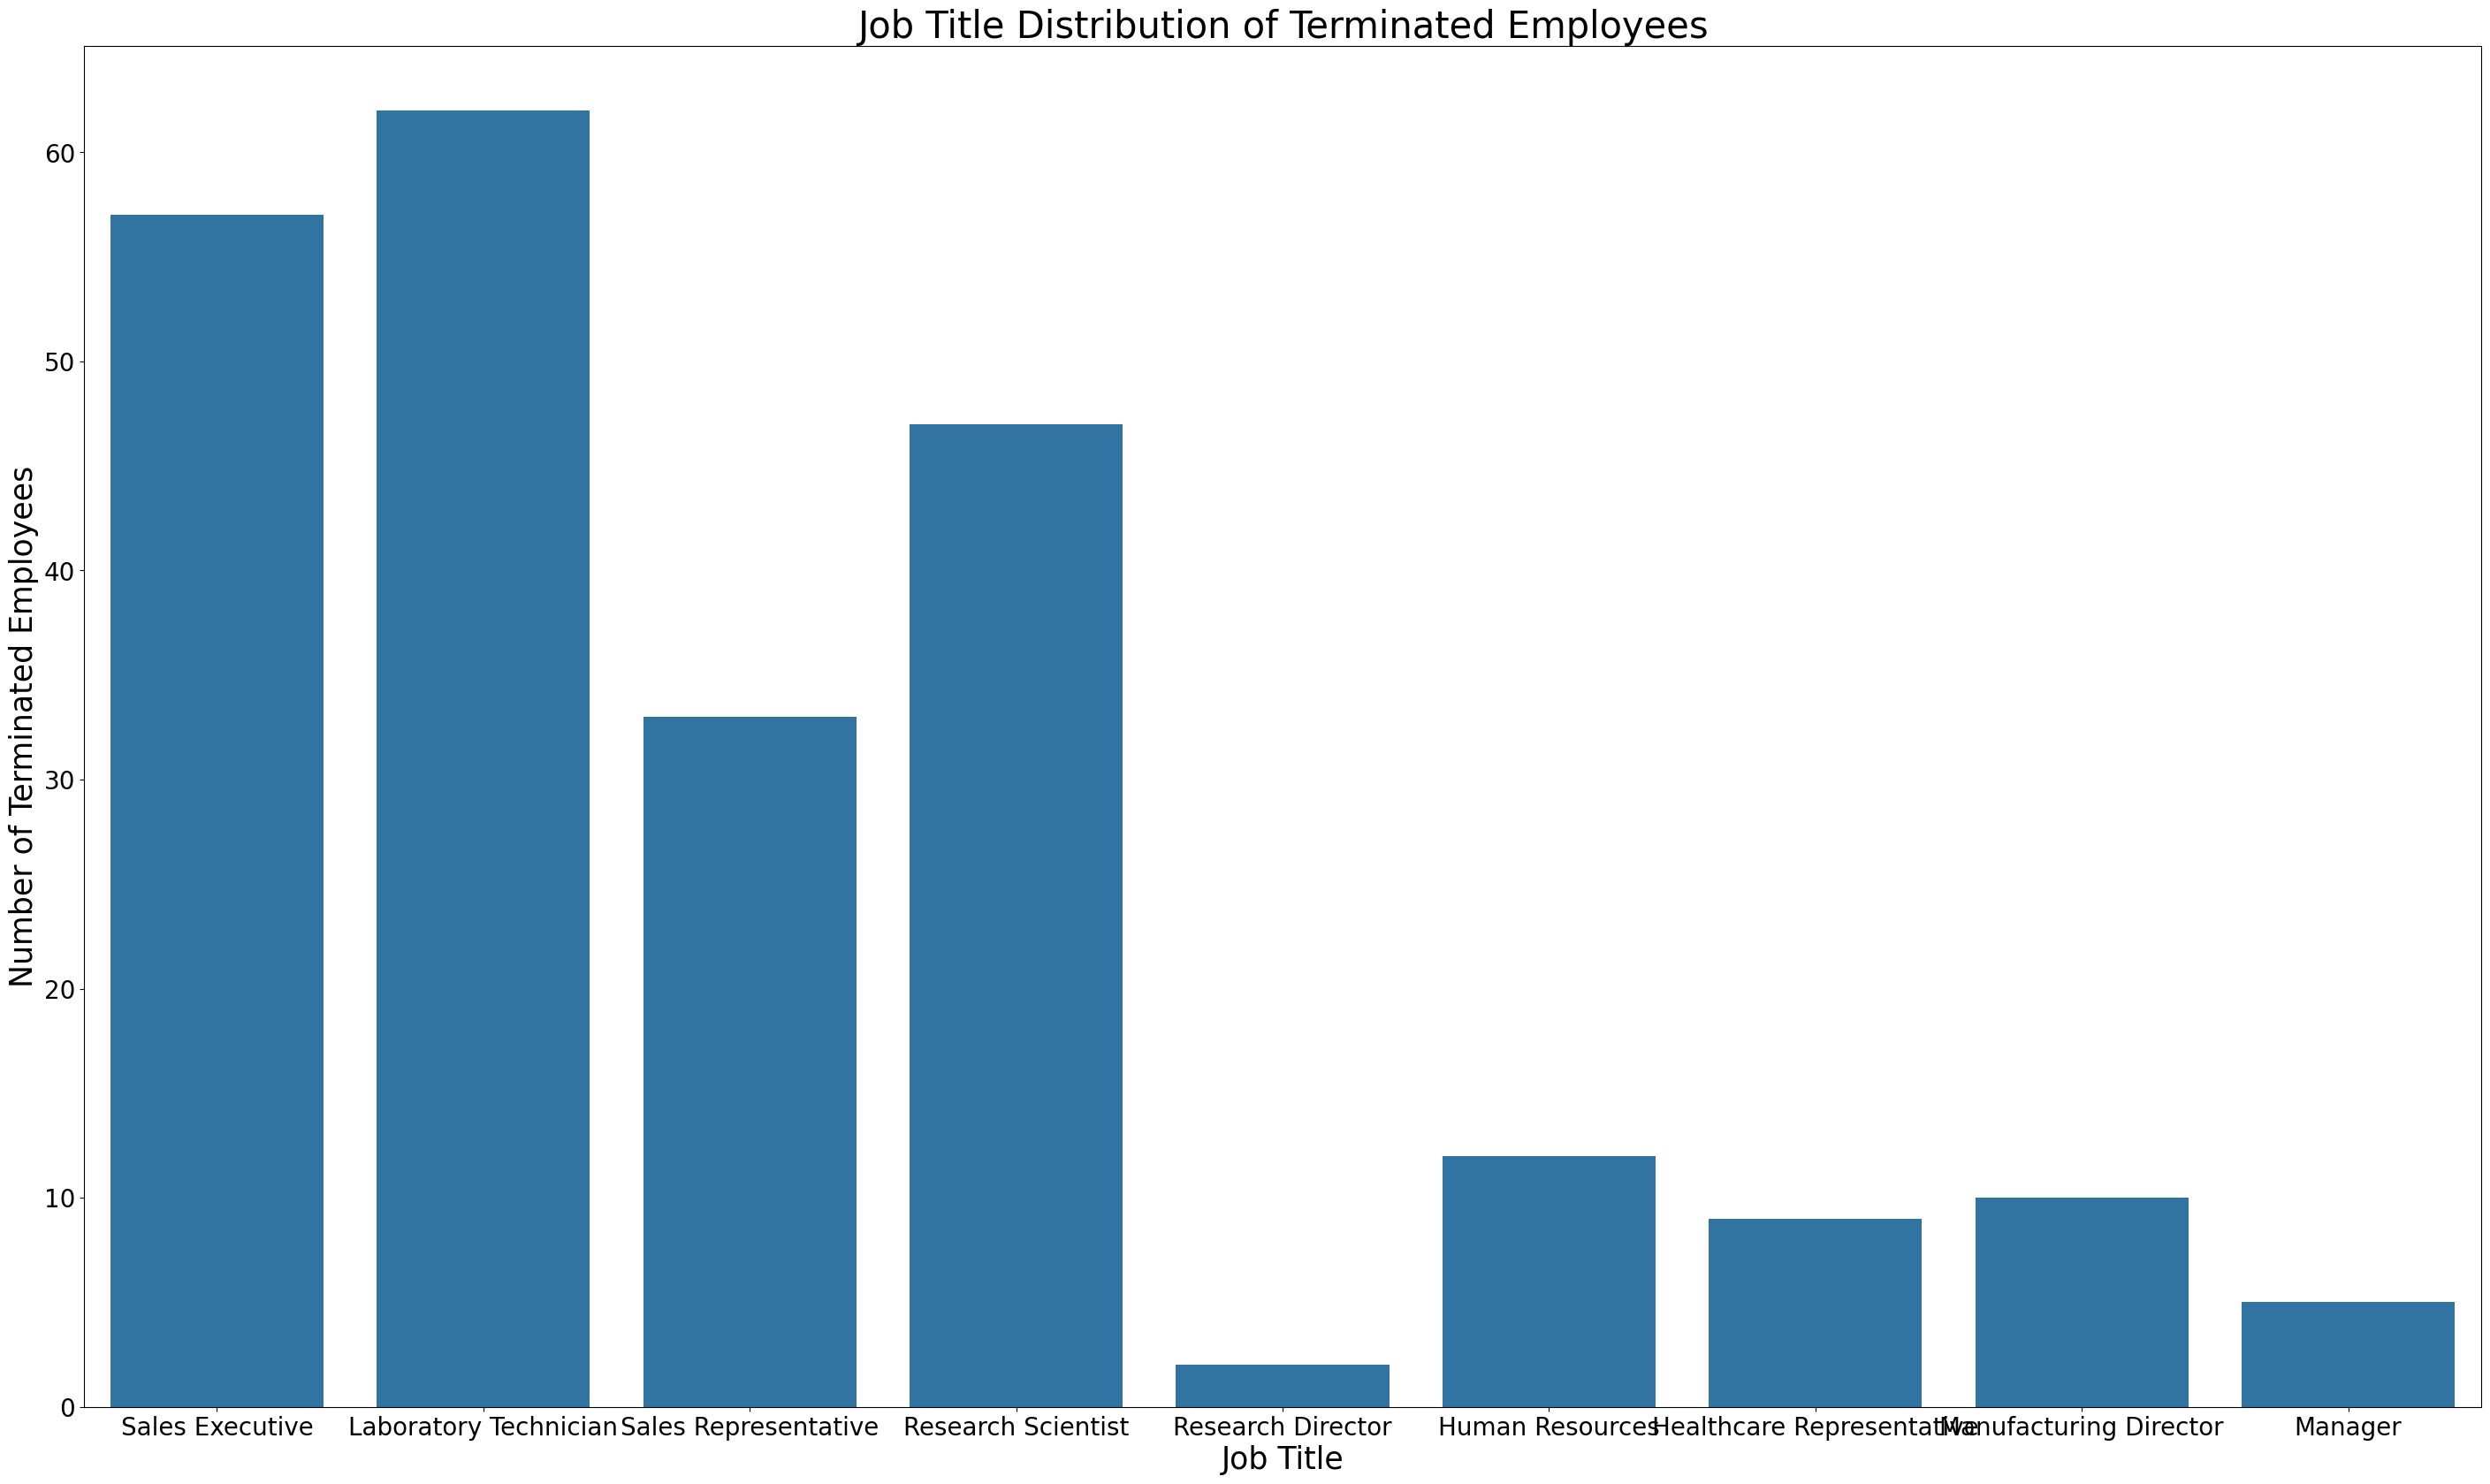

In [ ]:


# Plot the gender distribution of terminated employees
plt.figure(figsize=(35, 20))
sns.countplot(data=terminated_df, x='JobRole')
plt.title('Job Title Distribution of Terminated Employees', fontsize=30)
plt.xlabel('Job Title', fontsize=25)
plt.ylabel('Number of Terminated Employees', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Next, let's create a pie chart to view that same data above, but as percentages of the whole.

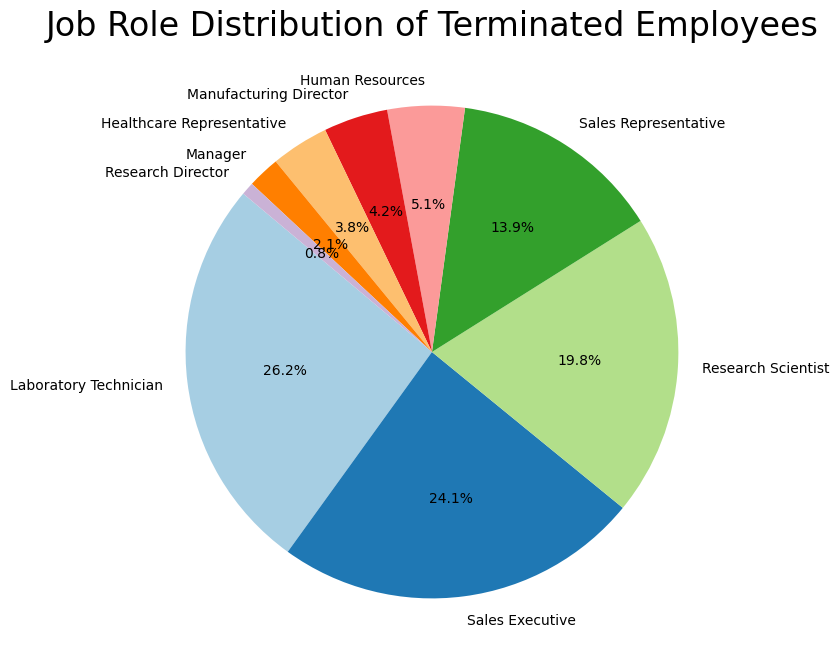

In [ ]:
# Calculate the distribution of job roles
jobrole_counts = terminated_df['JobRole'].value_counts()

# Plot the job role distribution of terminated employees as a pie chart
plt.figure(figsize=(12, 8))
plt.pie(jobrole_counts, labels=jobrole_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Job Role Distribution of Terminated Employees', fontsize=24)

# Show the plot
plt.show()

Let's use pairplot from the Seaborn library to view a variety of graphs.

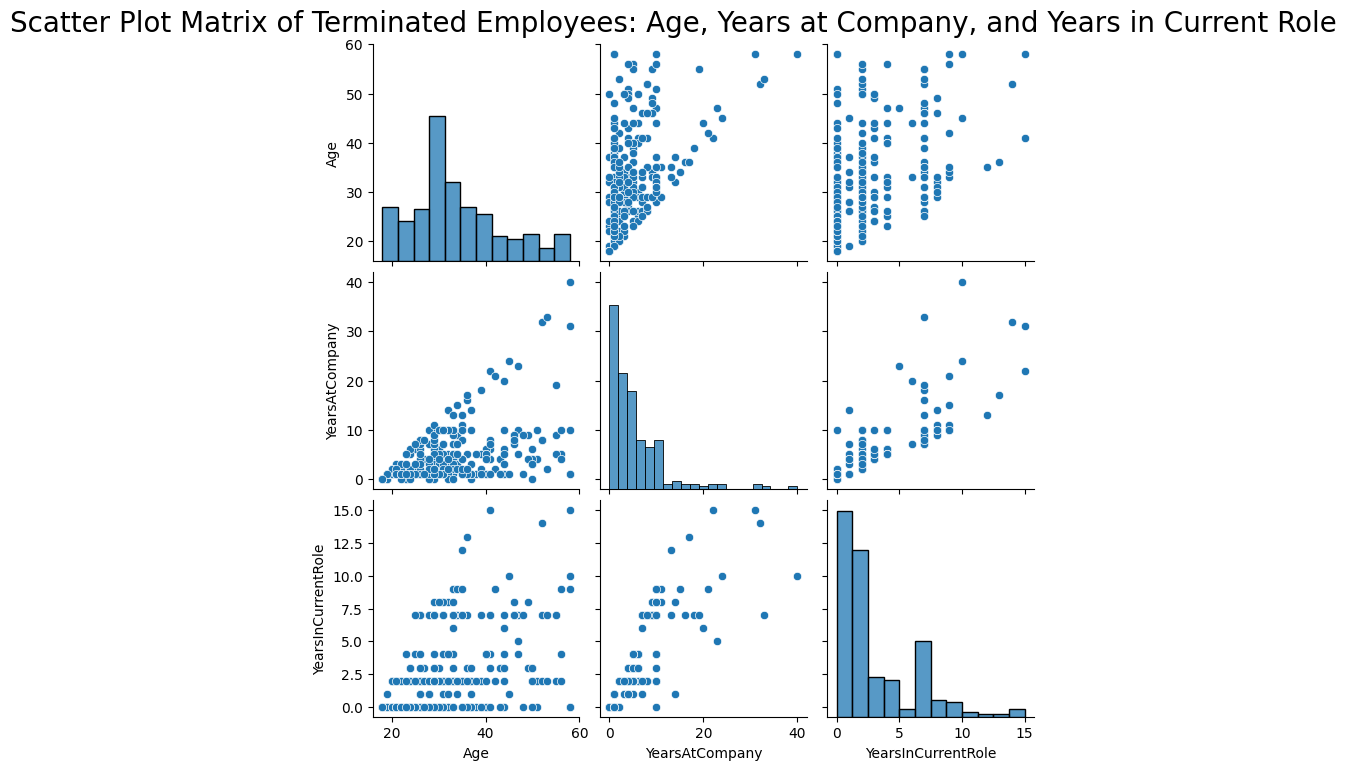

In [ ]:
# Plot using pairplot
sns.pairplot(terminated_df[['Age', 'YearsAtCompany', 'YearsInCurrentRole']])
plt.suptitle('Scatter Plot Matrix of Terminated Employees: Age, Years at Company, and Years in Current Role', y=1.02, fontsize=20)
plt.show()

We can see **'Attrition'** based on 'Job Satisfaction' and how most of the  employees who leave the company have lower ratings of 'Job Satisfaction'.

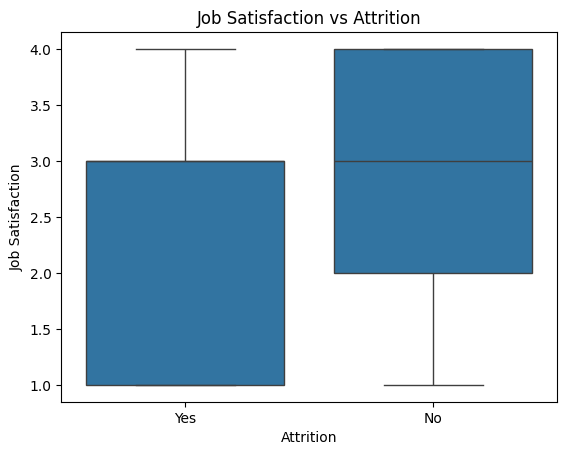

In [ ]:
sns.boxplot(data=df, x='Attrition', y='JobSatisfaction')
plt.title('Job Satisfaction vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Job Satisfaction')
plt.show()

Next, let's take a look at **'Monthly Income'**.  This is really just to get an idea of the distribution across the entire dataset.

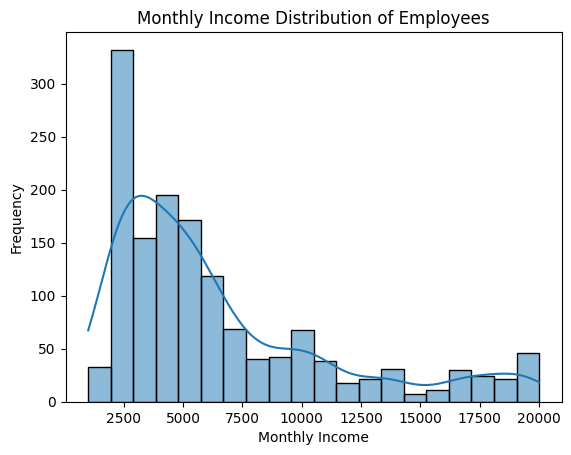

In [ ]:
sns.histplot(df['MonthlyIncome'], bins=20, kde=True)
plt.title('Monthly Income Distribution of Employees')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.show()

Now let's visualize that data as it relates to **'Attrition'**.  We can see employees who leave the company tend to have lower **'Monthly Income'**.

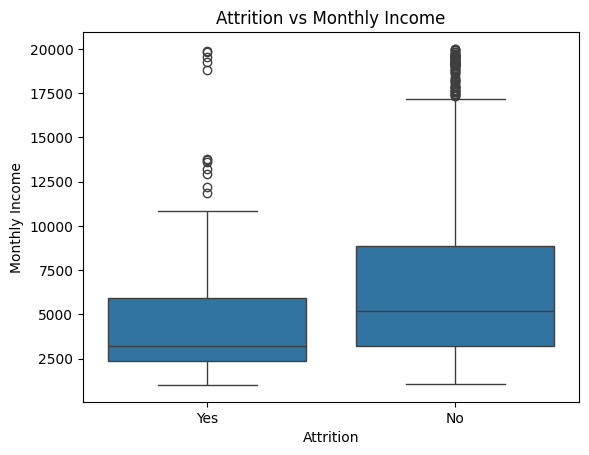

In [ ]:
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title('Attrition vs Monthly Income')
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

This below now looks at 'Attrition' vs Years at Company'.  It's interesting how similar these 2 graphs for **'Monthly Income'** and **'Years at Company'** are.  This all leads us to believe that fewer employees are sr level/executive and most are junior level or mid level.

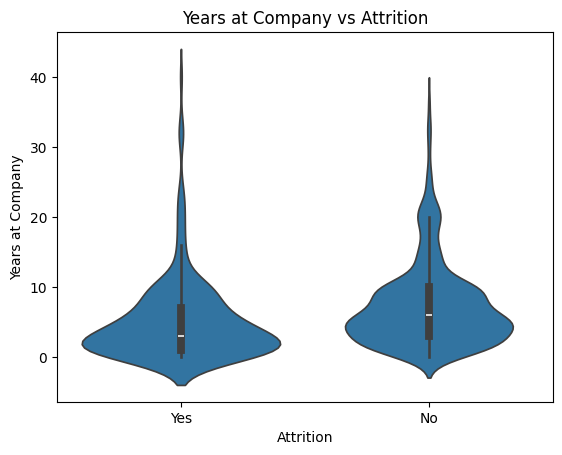

In [ ]:
sns.violinplot(data=df, x='Attrition', y='YearsAtCompany')
plt.title('Years at Company vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Years at Company')
plt.show()

let's take a look at **'Work-Life Balance'**, **'Environment Satisfaction'**, and then one of our engineered features **'Environment/Job Satisfaction'**.  Overall, it looks like these features don't seem to indicate if an employee leaves the company or not.

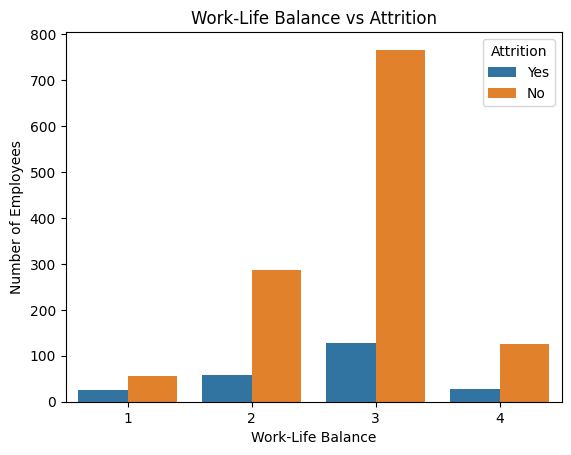

In [ ]:
sns.countplot(data=df, x='WorkLifeBalance', hue='Attrition')
plt.title('Work-Life Balance vs Attrition')
plt.xlabel('Work-Life Balance')
plt.ylabel('Number of Employees')
plt.show()

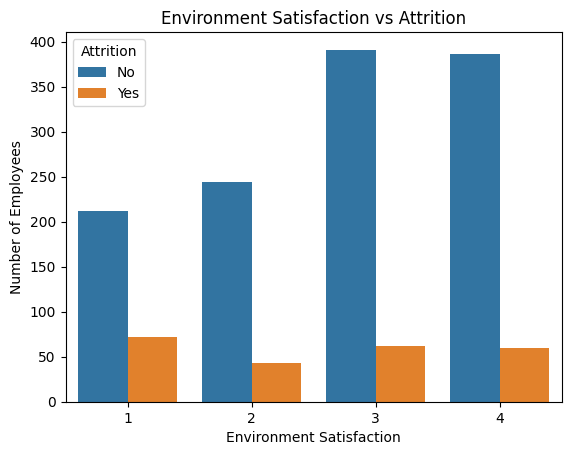

In [ ]:
sns.countplot(data=df, x='EnvironmentSatisfaction', hue='Attrition')
plt.title('Environment Satisfaction vs Attrition')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Number of Employees')
plt.show()

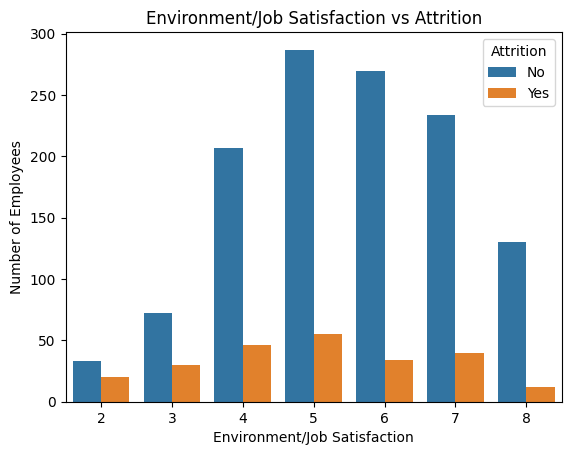

In [ ]:
sns.countplot(data=df, x='JobEnvSatisfaction', hue='Attrition')
plt.title('Environment/Job Satisfaction vs Attrition')
plt.xlabel('Environment/Job Satisfaction')
plt.ylabel('Number of Employees')
plt.show()


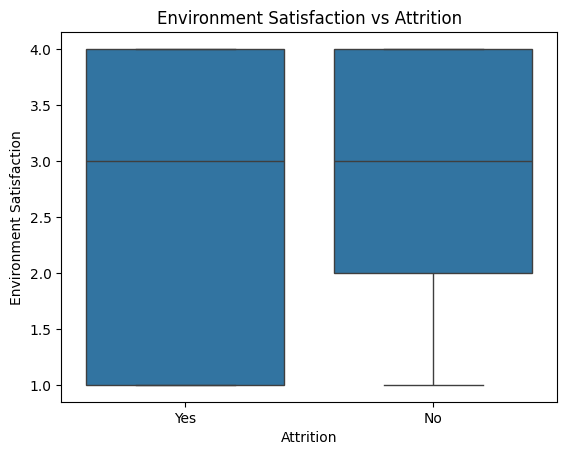

In [ ]:
sns.boxplot(data=df, x='Attrition', y='EnvironmentSatisfaction')
plt.title('Environment Satisfaction vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Environment Satisfaction')
plt.show()

Ok, so here is what we learned:  

* Most employees are junior or mid level  
* Most employees are under 40 and most employees who leave the company are under 40  
* Mostly males work here and are therefore more often leaving the company  
* Most employees leaving rarely travel  
* Research and Sales departments experience more Attrition  
* Job Satisfaction has minimal impact on Attrition  
* Employees making less money are more likely to experience Attrition  
* Less experienced employees are more likely to experience Attrition
* Work Life Balance has minimal impact on Attrition

Alright, we're almost ready to model.  Let's take a look at the data one more time.  As we can see, we need to encode our categorical features before we move on to the modeling.  Let's use **LabelEncoder and One-Hot Encoding**.

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsInCurrentRole_vs_YearsAtCompany,TotalYearsCurrentJob,JobEnvSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,8,0,1,6,4,0,5,0.666667,9,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,10,3,3,10,7,1,7,0.700000,14,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,7,3,3,0,0,0,0,0.000000,0,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,8,3,3,8,7,3,0,0.875000,7,7
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,6,3,3,2,2,2,2,1.000000,4,3


**Label Encoder** is great when there is an ordinal relationship in the data such as travel or overtime or Attrition.

In [141]:
label_encoder = LabelEncoder()

columns_to_encode = [
    'BusinessTravel',
    'OverTime',
    'Attrition'
]

for column in columns_to_encode:
#    df.loc[:, column] = label_encoder.fit_transform(df[column]).astype(int)
    df[column] = label_encoder.fit_transform(df[column])
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)
# Print df_clean to verify the encoding
df.head()
df.dtypes

Age                                       int64
Attrition                                 int64
BusinessTravel                            int64
DailyRate                                 int64
Department                               object
DistanceFromHome                          int64
Education                                 int64
EducationField                           object
EnvironmentSatisfaction                   int64
Gender                                   object
HourlyRate                                int64
JobInvolvement                            int64
JobLevel                                  int64
JobRole                                  object
JobSatisfaction                           int64
MaritalStatus                            object
MonthlyIncome                             int64
MonthlyRate                               int64
NumCompaniesWorked                        int64
OverTime                                  int64
PercentSalaryHike                       

And One-Hot Encoding is best when there is no ordinal relationship amongst the values, like in Department or Job Role.

In [142]:
columns_to_encode = ['Department',
                    'EducationField',
                    'Gender',
                    'JobRole',
                    'MaritalStatus']

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the data
encoded_data = ohe.fit_transform(df[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

# Drop the original columns and concatenate the encoded columns
df_encoded = df.drop(columns_to_encode, axis=1).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
df_cleaned = pd.concat([df_encoded, encoded_df], axis=1)

# Display the DataFrame
df_cleaned

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,2,1102,1,2,2,94,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,49,0,1,279,8,1,3,61,2,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,2,1373,2,2,4,92,2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33,0,1,1392,3,4,4,56,3,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,27,0,2,591,2,1,1,40,3,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,1,884,23,2,3,41,4,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,39,0,2,613,6,1,4,42,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,27,0,2,155,4,3,2,87,4,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,49,0,1,1023,2,3,4,63,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [148]:
# Select numeric columns to scale
numeric_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Apply the scaler to the numeric columns
df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])

### Modeling  

Now we can beign our modeling!  1st thing we need to do is create our X and y variables and then build our train and test sets.

In [145]:
# Seperate target and features
X = df_cleaned.drop('Attrition', axis=1) # all columns except the target column our our independent variables
y = df_cleaned['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

Now we need to address our **Class Imbalance**.  As we saw earlier, our minority class is roughly 16% of our data.  In a perfect world, the data would be evenly split 50/50.  However, we can still work with this data and use sampling techniques to improve our results.  We will combine SMOTE oversampling and Undersampling with stratification.  Undersampling with stratification reduces the number of samples in the majority class, while maintaining the class distribution.  This helps create a more balanced dataset and should improve modeling.

In [161]:
# Handle NaN values using SimpleImputer
#imputer = SimpleImputer(strategy='mean')
#X_train_imputed = imputer.fit_transform(X_train)
#X_test_imputed = imputer.transform(X_test)


# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=.75, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=.75, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler to the training data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced.shape}")
print(f"y_train shape after resampling: {y_train_balanced.shape}")

Class distribution before resampling:
Attrition
0    986
1    190
Name: count, dtype: int64

Class distribution after SMOTE:
Attrition
0    986
1    739
Name: count, dtype: int64

Class distribution after SMOTE and undersampling:
Attrition
0    985
1    739
Name: count, dtype: int64

X_train shape after resampling: (1724, 46)
y_train shape after resampling: (1724,)



Accuracy Score:
0.7619047619047619

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       247
           1       0.31      0.38      0.34        47

    accuracy                           0.76       294
   macro avg       0.59      0.61      0.60       294
weighted avg       0.79      0.76      0.77       294


Accuracy Score:
0.7619047619047619

Confusion Matrix:
[[206  41]
 [ 29  18]]


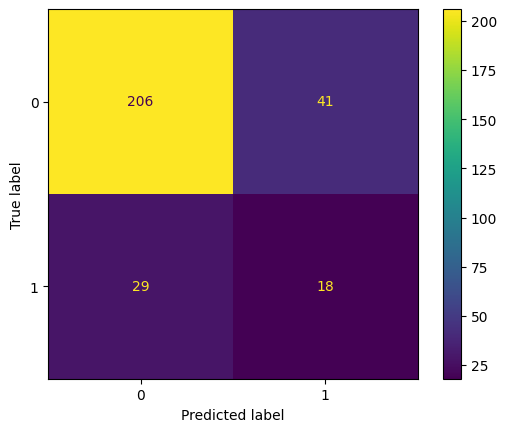

In [162]:
clf_tree =DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_tree.classes_).plot()
plt.show()


Accuracy Score:
0.7380952380952381

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       247
           1       0.25      0.32      0.28        47

    accuracy                           0.74       294
   macro avg       0.56      0.57      0.56       294
weighted avg       0.77      0.74      0.75       294


Accuracy Score:
0.7380952380952381

Confusion Matrix:
[[202  45]
 [ 32  15]]


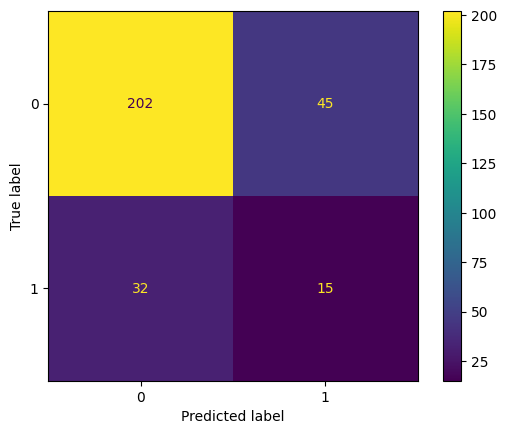

In [163]:
clf_balanced_tree =DecisionTreeClassifier(random_state=42)
clf_balanced_tree.fit(X_train_balanced, y_train_balanced)

y_pred = clf_balanced_tree.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_balanced_tree.classes_).plot()
plt.show()

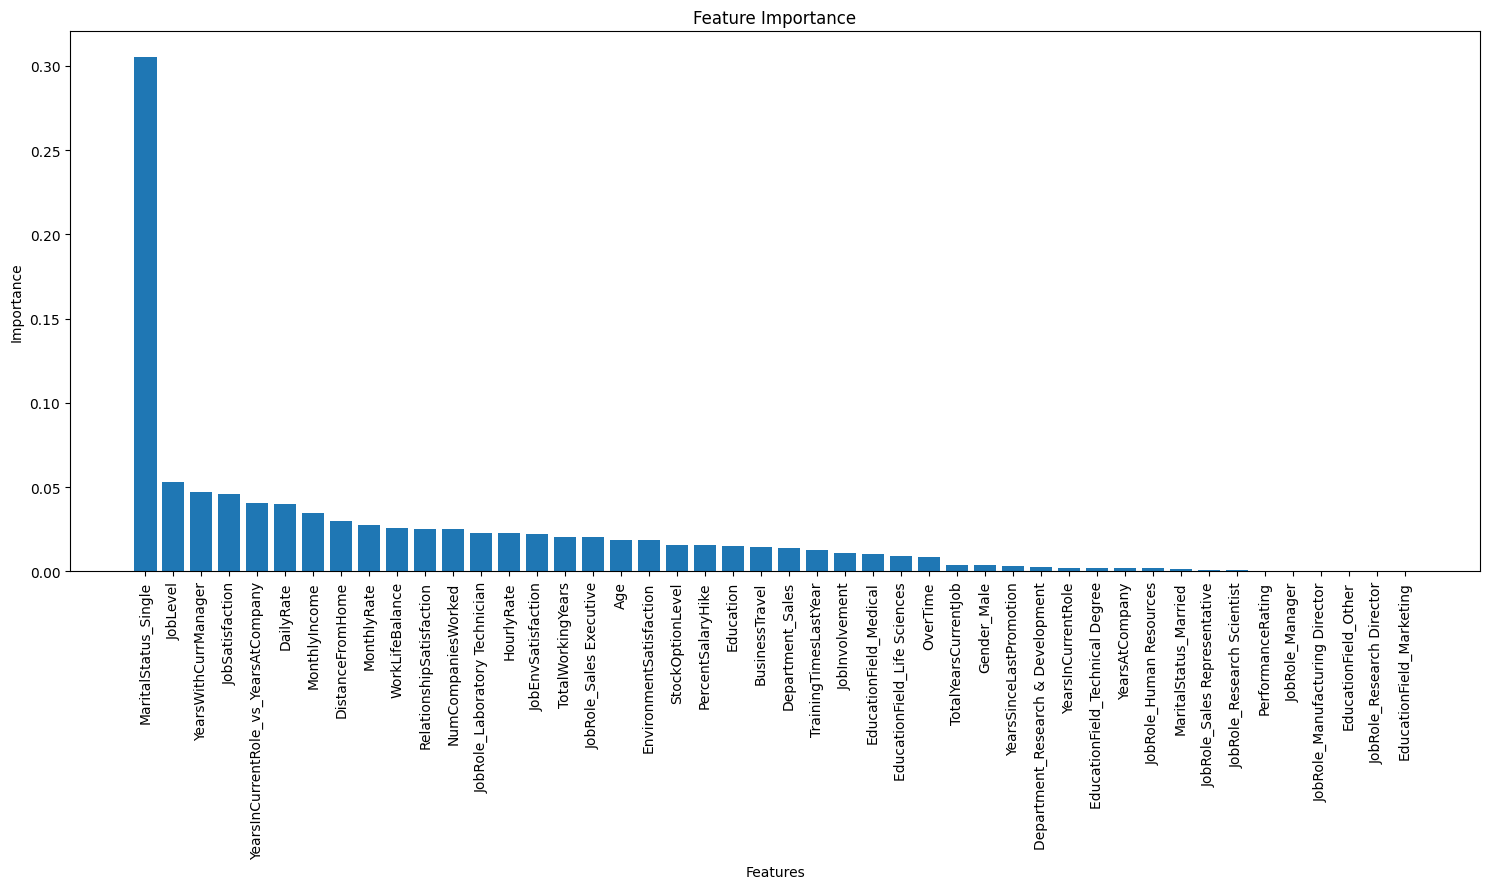

In [164]:
# Get feature importances
feature_importances = clf_balanced_tree.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(X_train_balanced.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_balanced.shape[1]), X_train_balanced.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Best parameters found:  {'class_weight': {0: 1, 1: 4}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 2}

Accuracy Score:
0.6360544217687075

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       247
           1       0.23      0.55      0.33        47

    accuracy                           0.64       294
   macro avg       0.56      0.60      0.54       294
weighted avg       0.78      0.64      0.68       294


Confusion Matrix:
[[161  86]
 [ 21  26]]


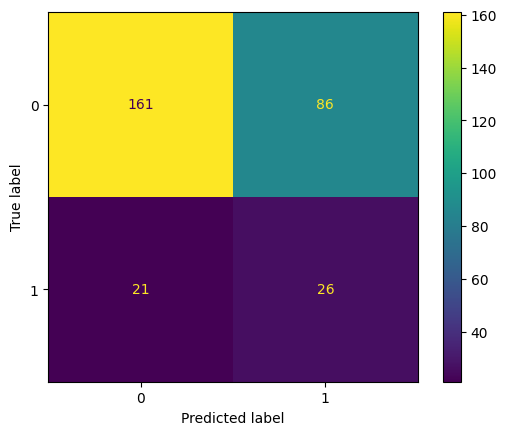

In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 100],
    'min_samples_split': [2, 15, 20],
    'min_samples_leaf': [1, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
}

# Initialize the classifier
clf_balanced_treecv = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_balanced_treecv, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()


Accuracy Score:
0.8367346938775511
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.43      0.06      0.11        47

    accuracy                           0.84       294
   macro avg       0.64      0.52      0.51       294
weighted avg       0.78      0.84      0.78       294

Confusion Matrix:
[[243   4]
 [ 44   3]]


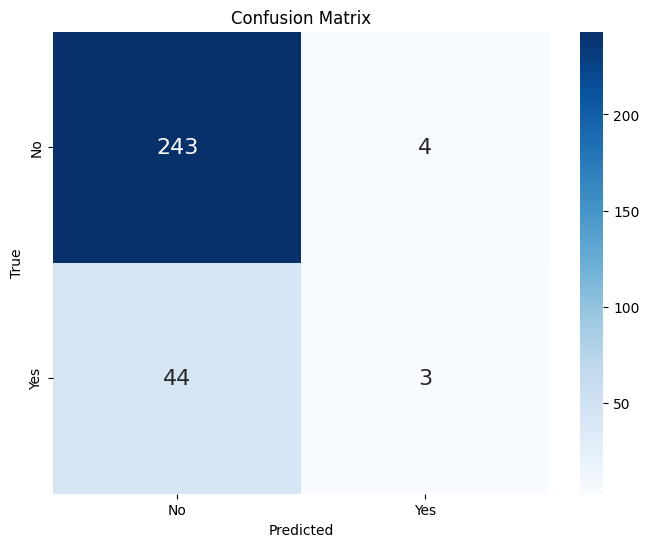

In [166]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_rf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf_rf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16},
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Accuracy Score:
0.8299319727891157
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       247
           1       0.40      0.13      0.19        47

    accuracy                           0.83       294
   macro avg       0.63      0.55      0.55       294
weighted avg       0.78      0.83      0.79       294

Confusion Matrix:
[[238   9]
 [ 41   6]]


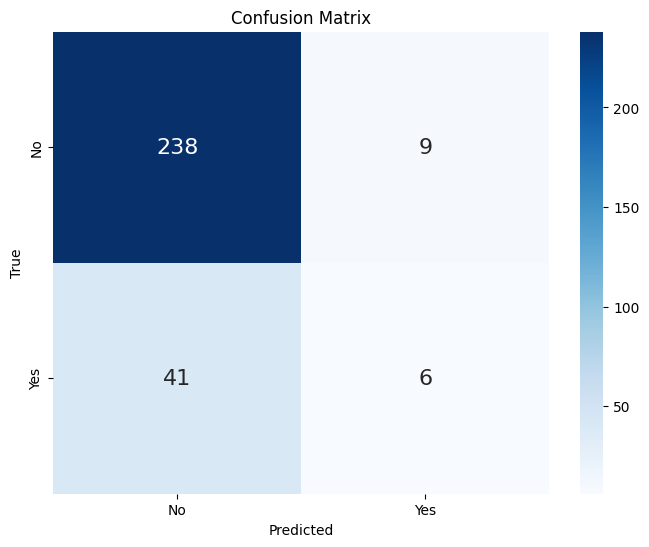

In [167]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf_rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_rf_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf_rf_balanced.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16},
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Accuracy Score:
0.7380952380952381

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       247
           1       0.25      0.32      0.28        47

    accuracy                           0.74       294
   macro avg       0.56      0.57      0.56       294
weighted avg       0.77      0.74      0.75       294


Confusion Matrix:
[[202  45]
 [ 32  15]]


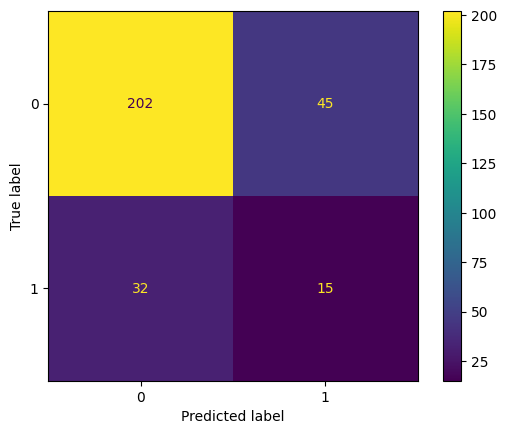

In [168]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming clf_balanced_tree, clf_balanced_treecv, and clf_rf are already trained

# Initialize the Voting Classifier with your existing models
voting_clf = VotingClassifier(estimators=[
    ('baseline', clf_balanced_tree),
    ('finetuned', clf_balanced_treecv),
    ('random_forest', clf_rf)
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

print("\nConfusion Matrix:")
cm_voting = confusion_matrix(y_test, y_pred_voting)
print(cm_voting)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=voting_clf.classes_).plot()
plt.show()


In [169]:
# Convert 'Attrition' column to binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical columns (excluding 'Attrition')
cat_cols = [column for column in df.columns if df[column].nunique() < 15 and df[column].dtype == 'object' and column != 'Attrition']

# Apply pd.get_dummies only to categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='uint8')

# Display the transformed DataFrame
print("\nTransformed DataFrame:")
print(df)


Transformed DataFrame:
      Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  Education  \
0      41        NaN               2       1102                 1          2   
1      49        NaN               1        279                 8          1   
2      37        NaN               2       1373                 2          2   
3      33        NaN               1       1392                 3          4   
4      27        NaN               2        591                 2          1   
...   ...        ...             ...        ...               ...        ...   
1465   36        NaN               1        884                23          2   
1466   39        NaN               2        613                 6          1   
1467   27        NaN               2        155                 4          3   
1468   49        NaN               1       1023                 2          3   
1469   34        NaN               2        628                 8          3   

      Environme

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   1470 non-null   int64  
 1   Attrition                             0 non-null      float64
 2   BusinessTravel                        1470 non-null   int64  
 3   DailyRate                             1470 non-null   int64  
 4   DistanceFromHome                      1470 non-null   int64  
 5   Education                             1470 non-null   int64  
 6   EnvironmentSatisfaction               1470 non-null   int64  
 7   HourlyRate                            1470 non-null   int64  
 8   JobInvolvement                        1470 non-null   int64  
 9   JobLevel                              1470 non-null   int64  
 10  JobSatisfaction                       1470 non-null   int64  
 11  MonthlyIncome    

In [171]:
df.corr()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
Age,1.000000,NaN,0.024751,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,...,-0.029856,-0.143176,0.294248,0.049726,0.185891,-0.146518,-0.002001,-0.175785,0.083919,-0.119185
Attrition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,0.024751,NaN,1.000000,-0.004086,-0.024469,0.000757,0.004174,0.026528,0.039062,0.019311,...,0.013346,-0.014328,0.012221,0.006567,0.033365,0.011829,-0.022251,-0.001866,0.057808,-0.012097
DailyRate,0.010661,NaN,-0.004086,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,...,-0.021156,-0.006728,-0.013224,-0.005302,-0.000021,-0.002624,-0.000513,0.005375,0.040035,-0.075835
DistanceFromHome,-0.001686,NaN,-0.024469,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,...,-0.024089,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,0.030232,-0.027445
Education,0.208034,NaN,0.000757,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,...,-0.005295,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.001865,0.004168
EnvironmentSatisfaction,0.010146,NaN,0.004174,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,...,-0.022014,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,-0.022180,0.009035
HourlyRate,0.024287,NaN,0.026528,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,...,-0.016189,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,0.036432,-0.033436
JobInvolvement,0.029820,NaN,0.039062,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,...,-0.004952,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.028324,-0.045253
JobLevel,0.509604,NaN,0.019311,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,...,-0.100922,-0.344608,0.552744,0.114896,0.414319,-0.387788,0.127490,-0.216559,0.050547,-0.087072


<Axes: >

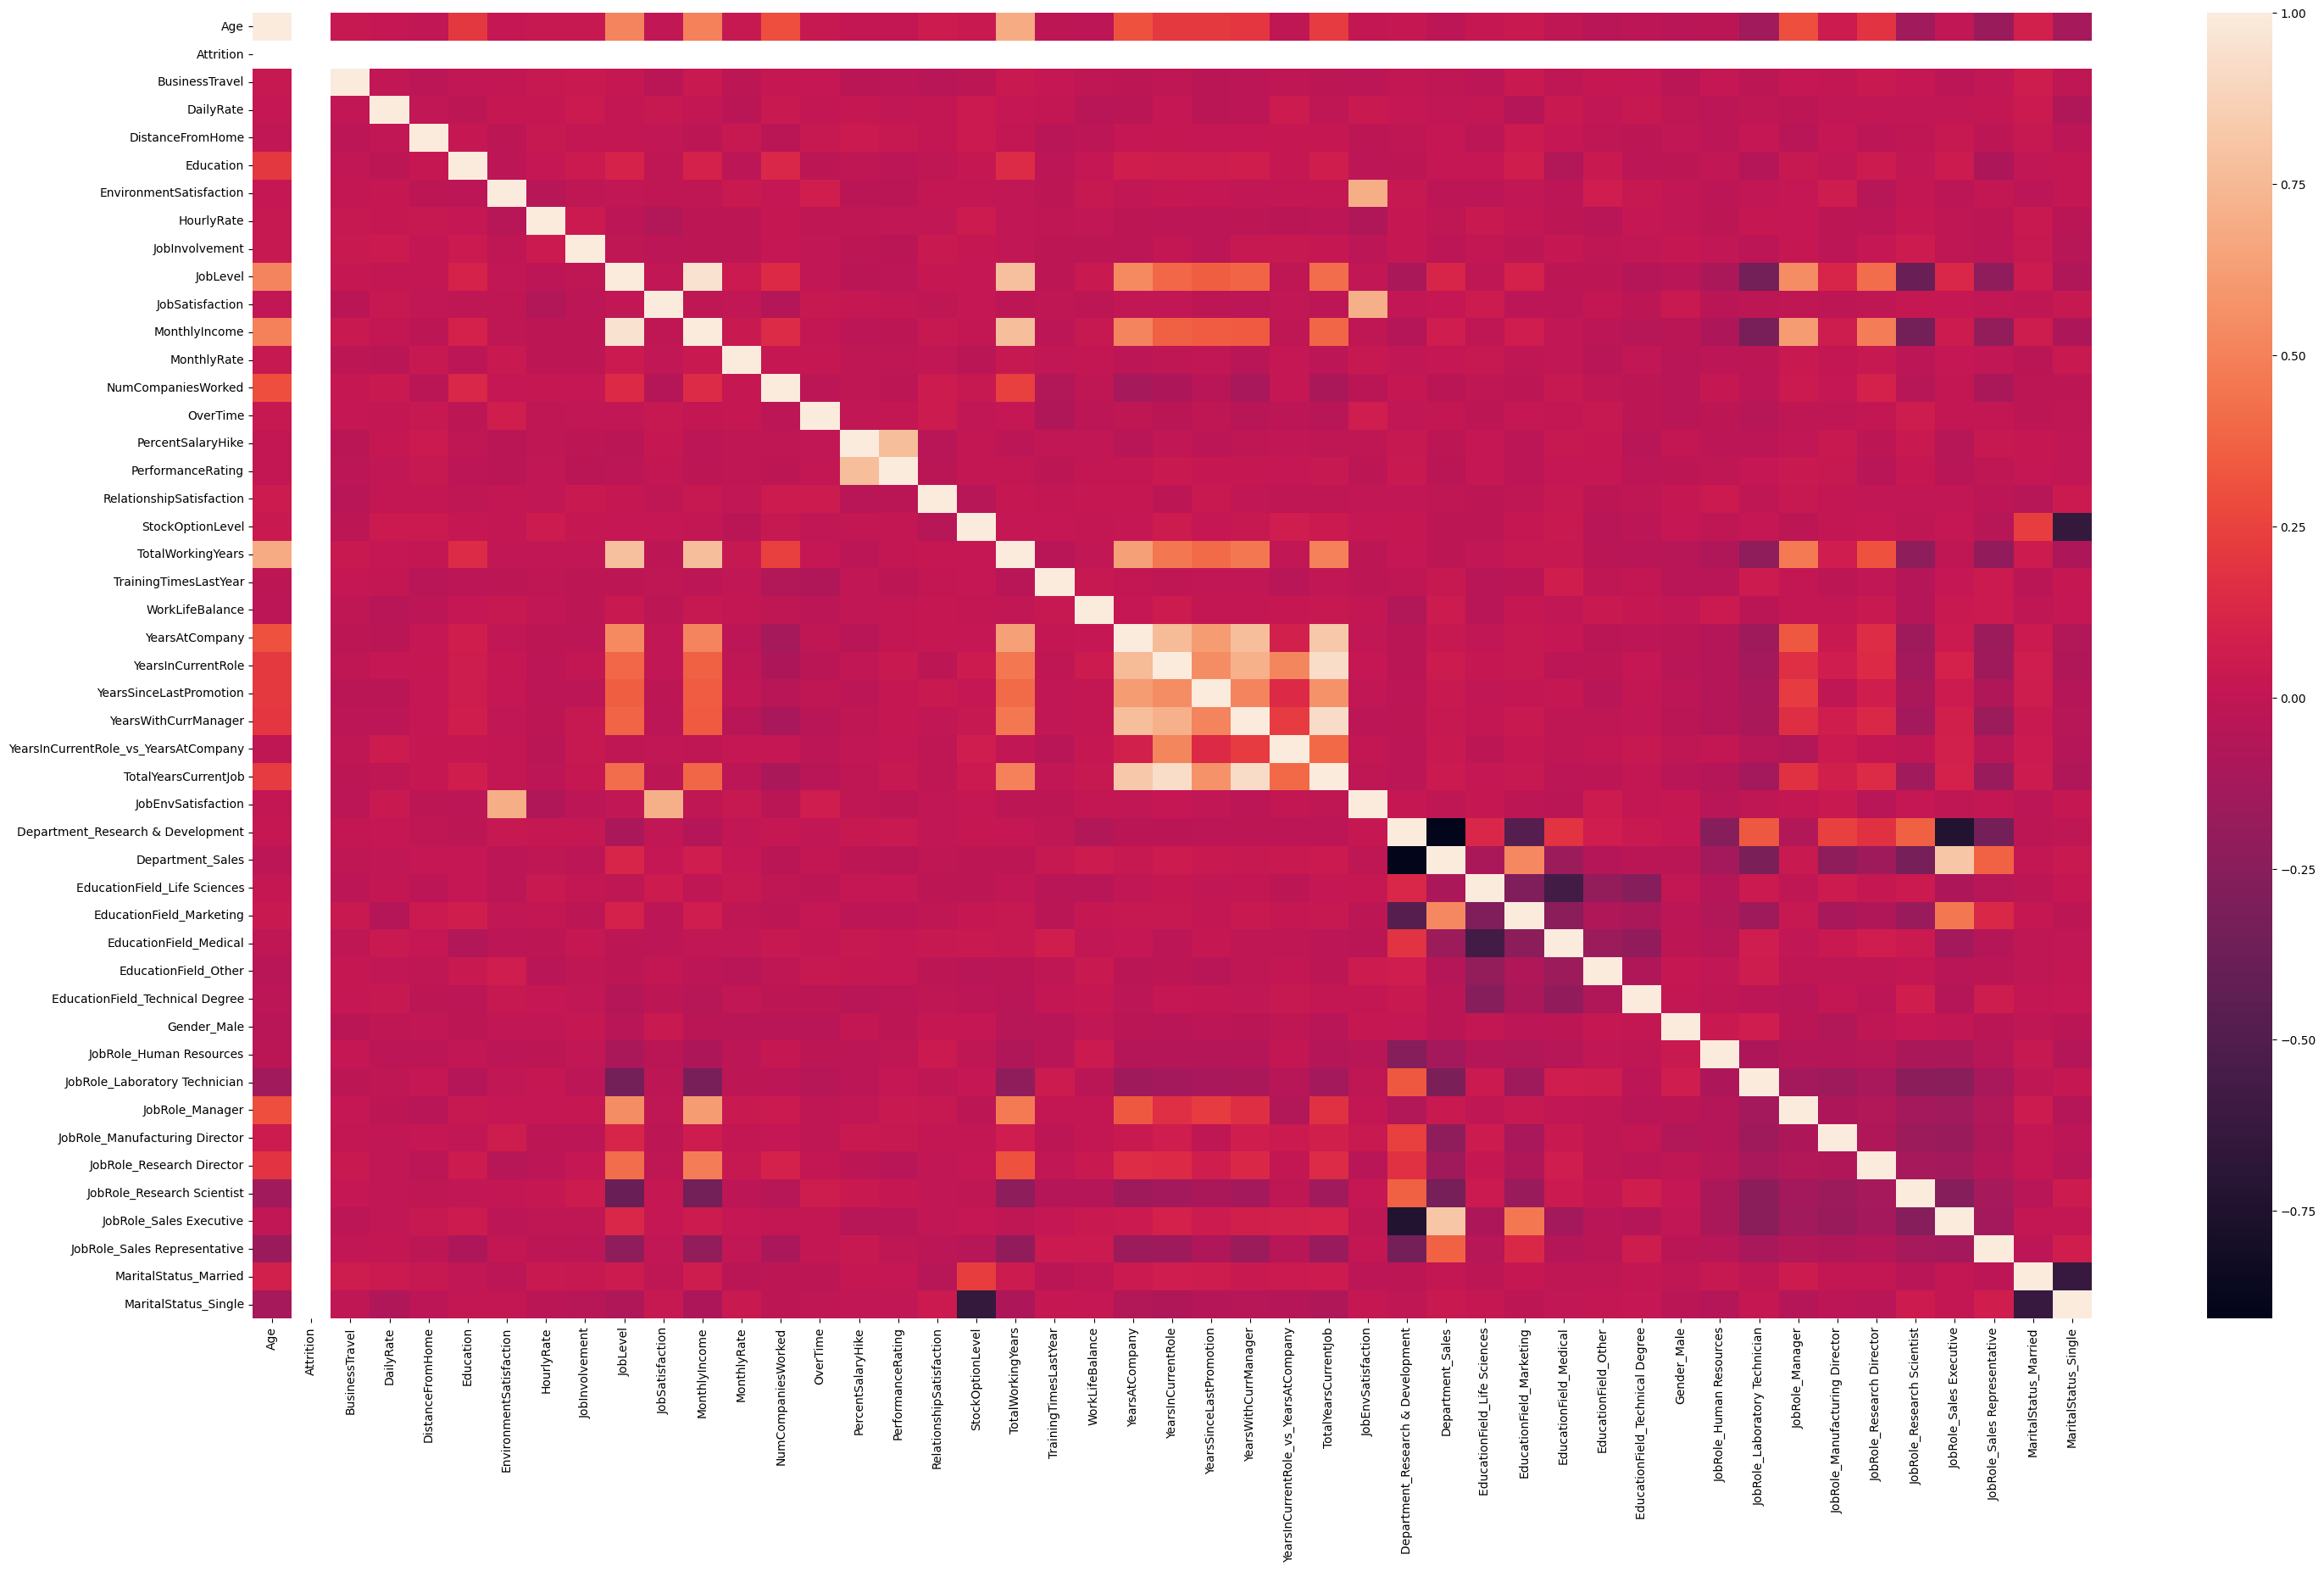

In [172]:
plt.figure(figsize=(35,20))
sns.heatmap(df.corr())

In [173]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

ValueError: Input y contains NaN.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)


    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear', penalty='l1')
lr_clf.fit(X_train_std, y_train)

evaluate(lr_clf, X_train_std, X_test_std, y_train, y_test)

In [ ]:
# Initialize your model (e.g., RandomForestClassifier)
model = RandomForestClassifier(n_estimators=100, bootstrap=False)

# Train the model
model.fit(X_train, y_train)

# Predictions on test set
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
print(f"CLASSIFICATION REPORT:\n{clf_report}")


# Evaluation metrics
#print("TESTING RESULTS: \n===============================")
#print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
#print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
#print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False,
#                                      class_weight={0:stay, 1:leave}
                                    )
rf_clf.fit(X_train, y_train)
evaluate(rf_clf, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numeric columns to scale
numeric_columns = df_final.select_dtypes(include=['int64', 'float64']).columns

# Apply the scaler to the numeric columns
df_final[numeric_columns] = scaler.fit_transform(df_final[numeric_columns])

In [ ]:
# Seperate target and features
X = df_final.drop('Attrition', axis=1) # all columns except the target column our our independent variables
y = df_final['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['Attrition'])

In [ ]:
# Print the shapes of the resulting DataFrames
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
# Check the class distribution in y_train and y_test
print("Class distribution in y_train:\n", y_train.value_counts())
print("Class distribution in y_test:\n", y_test.value_counts())

In [ ]:
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=.75, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler to the training data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced.shape}")
print(f"y_train shape after resampling: {y_train_balanced.shape}")

In [ ]:
clf_balanced_tree =DecisionTreeClassifier(random_state=42)
clf_balanced_tree.fit(X_train_balanced, y_train_balanced)

y_pred = clf_balanced_tree.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_balanced_tree.classes_).plot()
plt.show()

In [ ]:
# Get feature importances
feature_importances = clf_balanced_tree.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(X_train_balanced.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_balanced.shape[1]), X_train_balanced.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]  # Adjusted to put more emphasis on class '1'
}

# Initialize the classifier
clf_balanced_treecv = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_balanced_treecv, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()



In [ ]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]  # Adjusted to put more emphasis on class '1'
}

# Initialize the classifier
clf_balanced_tree = DecisionTreeClassifier(random_state=42)

# Create a scorer for F2 score
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_balanced_tree, param_grid=param_grid, cv=5, scoring=f2_scorer, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()


# Most Accurate Model

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_rf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf_rf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16},
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming clf_balanced_tree, clf_balanced_treecv, and clf_rf are already trained

# Initialize the Voting Classifier with your existing models
voting_clf = VotingClassifier(estimators=[
    ('baseline', clf_balanced_tree),
    ('finetuned', clf_balanced_treecv),
    ('random_forest', clf_rf)
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

print("\nConfusion Matrix:")
cm_voting = confusion_matrix(y_test, y_pred_voting)
print(cm_voting)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=voting_clf.classes_).plot()
plt.show()



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Assuming clf_balanced_tree, clf_balanced_treecv, and clf_rf are already trained

# Initialize the Voting Classifier with adjusted class weights and hyperparameter tuning
voting_clf = VotingClassifier(estimators=[
    ('baseline', clf_balanced_tree),
    ('finetuned', clf_balanced_treecv),
    ('random_forest', clf_rf)
], voting='soft')

# Define the parameter grid for GridSearchCV
param_grid = {
    'voting': ['soft'],
    'weights': [[1, 1, 1], [1, 2, 1], [1, 1, 2], [1, 3, 1], [1, 1, 3]],  # Adjust weights to emphasize class '1'
    'flatten_transform': [True, False]
}
from sklearn.metrics import make_scorer, recall_score

# Define a custom scoring function emphasizing recall for class '1'
custom_scorer = make_scorer(recall_score, pos_label=1)

# Initialize GridSearchCV with the custom scorer
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()


In [ ]:
df_final = df_final.drop(columns=[
    'JobRole_Sales Executive',
    'MaritalStatus_Married',
    'YearsInCurrentRole',
    'EducationField_Life Sciences',
    'RelationshipSatisfaction',
    'PerformanceRating',
    'EducationField_Other',
    'JobSatisfaction',
    'OverTime',
    'FrequentBusinessTravel',
    'BusinessTravel',
    'JobRole_Research Director',
    'JobRole_Manager',
    'JobRole_Manufacturing Director'
])

In [ ]:
# Seperate target and features
X = df_final.drop('Attrition', axis=1) # all columns except the target column our our independent variables
y = df_final['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['Attrition'])

In [ ]:
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=.75, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler to the training data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced.shape}")
print(f"y_train shape after resampling: {y_train_balanced.shape}")

In [ ]:
clf =DecisionTreeClassifier(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

y_pred = clf.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()
plt.show()

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16},
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Tips to Improve Models  
* GridsearchCV
* Play around with SMOTE
* Remove Unimportant Features
* Ensemble on model maxxed on 'yes' and 'no'
* Receiver Operater Characteristic Curve (ROC)- Area Under the Curve (AUC)
* CV Scores

In [ ]:
len(y_train_balanced)

In [ ]:
len(y_train)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot box plots for each numeric column
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 5, i)  # Adjust the layout based on the number of columns
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

# Adjust the IQR threshold
threshold = 3.0  # Example: use a higher threshold to identify fewer outliers

# Identify outliers using the IQR method
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - threshold * IQR)) | (df[numeric_cols] > (Q3 + threshold * IQR))).any(axis=1)
print(f'Number of outliers: {outliers.sum()}')

# Remove outliers
df_clean = df[~outliers]

# Check the shape of the dataset before and after removing outliers
print(f'Original dataset shape: {df.shape}')
print(f'Cleaned dataset shape: {df_clean.shape}')


In [ ]:
label_encoder = LabelEncoder()

columns_to_encode = [
    'BusinessTravel',
    'OverTime',
    'Attrition'
]

for column in columns_to_encode:
    df_clean.loc[:, column] = label_encoder.fit_transform(df_clean[column])

# Print df_clean to verify the encoding
df_clean.head()

In [ ]:
columns_to_encode = ['Department',
                    'EducationField',
                    'Gender',
                    'JobRole',
                    'MaritalStatus']

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the data
encoded_data = ohe.fit_transform(df_clean[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

# Drop the original columns and concatenate the encoded columns
df_encoded = df_clean.drop(columns_to_encode, axis=1).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
df_cleaned = pd.concat([df_encoded, encoded_df], axis=1)

# Display the DataFrame
df_cleaned

In [ ]:
# Separate target and features
X = df_cleaned.drop('Attrition', axis=1)  # Check df_clean to ensure it's correctly prepared
y = df_cleaned['Attrition']

# Check shapes
print(X.shape)  # Should match the number of rows in df_clean minus 1 (for dropped column)
print(y.shape)  # Should match the number of rows in df_clean

# Split the data into train and test sets
#from sklearn.model_selection import train_test_split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


In [ ]:
# Print the shapes of the resulting DataFrames
print(f"X_train shape: {X_train_clean.shape}")
print(f"X_test shape: {X_test_clean.shape}")
print(f"y_train shape: {y_train_clean.shape}")
print(f"y_test shape: {y_test_clean.shape}")

In [ ]:
# Check the class distribution in y_train and y_test
print("Class distribution in y_train:\n", y_train_clean.value_counts())
print("Class distribution in y_test:\n", y_test_clean.value_counts())

In [ ]:
# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote_clean, y_train_smote_clean = smote.fit_resample(X_train_clean, y_train_clean)

# Apply RandomUnderSampler to the training data
X_train_balanced_clean, y_train_balanced_clean = under_sampler.fit_resample(X_train_smote_clean, y_train_smote_clean)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced_clean.shape}")
print(f"y_train shape after resampling: {y_train_balanced_clean.shape}")

In [ ]:
clf_clean =DecisionTreeClassifier(random_state=42)
clf_clean.fit(X_train_balanced_clean, y_train_balanced_clean)

y_pred_clean = clf_clean.predict(X_test_clean)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test_clean, y_pred_clean))
print("\nClassification Report:")
print(classification_report(y_test_clean, y_pred_clean))

print("\nAccuracy Score:")
print(accuracy_score(y_test_clean, y_pred_clean))

print("\nConfusion Matrix:")
cm_clean_tree = confusion_matrix(y_test_clean, y_pred_clean)
print(cm_clean_tree)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_clean_tree, display_labels=clf_clean.classes_).plot()
plt.show()

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16},
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()